In [46]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

# Election data

## Get Geography Data

In [48]:
# Load the data
df_geo = pd.read_csv('Data/processed/Geografi.csv', sep=';')
df_geo.columns = df_geo.columns.str.replace(' ', '', regex=True)

# Filter the data to only keep Copnhagen and its surroundings
df_geo_cph = df_geo.query("Storkredsnavn=='Københavns Storkreds' | Storkredsnavn=='Københavns Omegn'").drop_duplicates()
df_geo_cph['KredsNr'] = df_geo_cph['KredsNr'].astype(str)

# Create a list of unique KredsNr values
KredsNr_list = df_geo_cph['KredsNr'].unique()

In [49]:
df_geo_cph.head(3)

,ValgstedId,KommuneNr,KredsNr,StorkredsNr,LandsdelsNr,Valgstednavn,Kommunenavn,Kredsnavn,Storkredsnavn,Landsdelsnavn,Valgstedstart,Valgstedstop
0,101001,101,1,1,1,1. Østerbro,København,1. Østerbro,Københavns Storkreds,Hovedstaden,20150601,99991231
1,101002,101,1,1,1,1. Nord,København,1. Østerbro,Københavns Storkreds,Hovedstaden,20150601,99991231
2,101003,101,1,1,1,1. Syd,København,1. Østerbro,Københavns Storkreds,Hovedstaden,20150601,99991231


In [45]:
df_geo_cph.value_counts('Kredsnavn')

Kredsnavn
7. Brønshøj        9
12. Tårnby         8
5. Nørrebro        7
9. Vesterbro       7
1. Østerbro        6
8. Valby           6
2. Sundbyvester    5
6. Utterslev       5
11. Slots          4
10. Falkoner       4
4. Sundbyøster     4
3. Indre By        4
Name: count, dtype: int64

In [50]:
df_geo_cph.value_counts('Valgstednavn')

Valgstednavn
1. Nord        1
1. Nordvest    1
1. Syd         1
1. Vest        1
1. Øst         1
              ..
Korsvejen      1
Løjtegården    1
Pilegården     1
Tårnby         1
Vestamager     1
Name: count, Length: 69, dtype: int64

In [10]:
df_geo_cph.value_counts('KommuneNr')

KommuneNr
101    53
147     8
185     6
155     2
Name: count, dtype: int64

## Get Election Data

In [51]:
# Load the election data
df_elec_data = pd.read_csv('Data/processed/Valgdata.csv', sep=';')
df_elec_data.columns = df_elec_data.columns.str.replace(' ', '', regex=True)

# Filter the election data to only keep the relevant KredsNr
df_elec_cph = df_elec_data[df_elec_data['KredsNr'].isin(KredsNr_list)]

In [52]:
df_elec_cph.head(3)

,Gruppe,KredsNr,StorKredsNr,LandsdelsNr,FV2015-Stemmeberettigede,FV2015-Afgivnestemmer,FV2015-Blankestemmer,FV2015-Andreugyldigestemmer,FV2015-Gyldigestemmer,FV2015-A.Socialdemokratiet,...,"FV2022-Q.FrieGrønne,DanmarksNyeVenstrefløjsparti",FV2022-Å.Alternativet,FV2022-2.Udenforpartierne,FV2022-3.Udenforpartierne,FV2022-P.StramKurs,FV2022-Æ.Danmarksdemokraterne-IngerStøjberg,FV2022-4.Udenforpartierne,FV2022-E.KlausRiskærPedersen,FV2022-5.Udenforpartierne,FV2022-6.Udenforpartierne
0,101002,1,1,1,53634,46748,312,142,46294,10634,...,529,4378,15,-,-,558,-,-,-,-
1,101009,2,1,1,44476,36980,327,155,36498,8223,...,1129,3771,22,-,-,812,-,-,-,-
2,101011,3,1,1,40705,34365,221,125,34019,6562,...,304,4068,20,-,-,338,-,-,-,-


#### Format into long format

In [13]:
# Select vote cols (start with "FV")
vote_columns = [col for col in df_elec_cph.columns if col.startswith("FV")]

# Melt the dataframe to long format
df_elec_cph_long = df_elec_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=vote_columns,
    var_name='YearParty',
    value_name='Votes'
)

# Split the 'YearParty' column into 'Year' and 'Party'
df_elec_cph_long[['Year', 'Partinavn']] = df_elec_cph_long['YearParty'].str.extract(r'FV(\d{4})-(.+)')

# Drop columns and reorder
df_elec_cph_long = df_elec_cph_long.drop(columns='YearParty')
df_elec_cph_long = df_elec_cph_long[['Gruppe', 'KredsNr', 'Year', 'Partinavn', 'Votes']]


In [14]:
df_elec_cph_long.head(3)

,Gruppe,KredsNr,Year,Partinavn,Votes
0,101002,1,2015,Stemmeberettigede,53634
1,101009,2,2015,Stemmeberettigede,44476
2,101011,3,2015,Stemmeberettigede,40705


In [15]:
df_elec_cph_long.isnull().sum()

Gruppe       0
KredsNr      0
Year         0
Partinavn    0
Votes        0
dtype: int64

## Get meta data for the parties

In [16]:
# Load the parties metadata
df_parties_meta = pd.read_csv('Data/processed/Partier.csv', sep=';')
df_parties_meta.columns = df_parties_meta.columns.str.replace(' ', '', regex=True)

In [19]:
df_parties_meta

,Partinavn,Kortpartinavn,Parti,Nummer
0,Stemmeberettigede,Berret,BE,-5
1,Afgivne stemmer,Total,TO,-4
2,Blanke stemmer,Blanke,UB,-3
3,Andre ugyldige stemmer,Ugyldige,UA,-2
4,Gyldige stemmer,Gyldige,GY,-1
5,A. Socialdemokratiet,Socialdemokratiet,A,1
6,B. Det Radikale Venstre,Radikale Venstre,B,2
7,B. Radikale Venstre,Radikale Venstre,B,2
8,C. Det Konservative Folkeparti,Konservative Folkeparti,C,3
9,D. Centrum-Demokraterne,Centrum-Demokraterne,D,4


In [20]:
# Merge the election data with the parties metadata
df_elec_cph_long = pd.merge(
    df_elec_cph_long,
    df_parties_meta[['Partinavn', 'Kortpartinavn', 'Parti']],
    on='Partinavn',
    how='left'
)

In [21]:
# Merge with the geography data
df_elec_cph_long = pd.merge(
    df_elec_cph_long,
    df_geo_cph[['KredsNr', 'Kredsnavn', 'Kommunenavn']],
    on='KredsNr',
    how='left'
)

In [22]:
df_elec_cph_long

,Gruppe,KredsNr,Year,Partinavn,Votes,Kortpartinavn,Parti,Kredsnavn,Kommunenavn
0,101002,1,2015,Stemmeberettigede,53634,Berret,BE,1. Østerbro,København
1,101002,1,2015,Stemmeberettigede,53634,Berret,BE,1. Østerbro,København
2,101002,1,2015,Stemmeberettigede,53634,Berret,BE,1. Østerbro,København
3,101002,1,2015,Stemmeberettigede,53634,Berret,BE,1. Østerbro,København
4,101002,1,2015,Stemmeberettigede,53634,Berret,BE,1. Østerbro,København
...,...,...,...,...,...,...,...,...,...
11587,185006,12,2022,6.Udenforpartierne,-,NaN,NaN,12. Tårnby,Tårnby
11588,185006,12,2022,6.Udenforpartierne,-,NaN,NaN,12. Tårnby,Tårnby
11589,185006,12,2022,6.Udenforpartierne,-,NaN,NaN,12. Tårnby,Tårnby
11590,185006,12,2022,6.Udenforpartierne,-,NaN,NaN,12. Tårnby,Tårnby


# Population Data

In [53]:
# Load the population data
df_population = pd.read_csv("Data/processed/Befolkning.csv", sep=';', low_memory=False)
df_population.columns = df_population.columns.str.replace(' ', '', regex=True)

# Filter the population data to only keep the relevant KredsNr
df_population['KredsNr'] = df_population['KredsNr'].astype(str)
df_population_cph = df_population[df_population['KredsNr'].isin(KredsNr_list)]

In [54]:
# Drop columns with all NaN values
df_population_cph = df_population_cph.replace("-", np.nan)
df_population_cph = df_population_cph.dropna(axis=1, how='all')

In [55]:
len(df_population_cph.columns)

5824

## Get demographics data

In [ ]:
# search for the column with exactly 'FV2005' in the name
df_population_cph.columns[df_population_cph.columns.str.contains('FV2005')]

# it starts with exactly exactly 'FV2005'



Gruppe                                                                                                                    int64
KredsNr                                                                                                                  object
StorKredsNr                                                                                                              object
LandsdelsNr                                                                                                              object
FV2015-Antalpersoneropgjortefterstatsborgerskabkønogaldersgrupper_Kvinder0-4år_01.Danmark                                object
                                                                                                                          ...  
FV2022-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_09.Folke-ogtjenestemandspension_12.Uoplystaktivitet    object
FV2022-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_10.Efterløn_12.Uoplystaktivitet       

In [73]:
demographics_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Antalpersoneropgjortefter" in col
]

# Melt the DataFrame
df_pop_demographics = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=demographics_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract the fields using regex
# Pattern: FV<year>-Antalpersoner..._<Gender><Age>_<CitizenshipCode>.<CitizenshipName>
df_pop_demographics[['Year', 'GenderAge', 'Citizenship']] = df_pop_demographics['RawColumn'].str.extract(
    r'FV(\d{4})-Antalpersoner.*?_(\w+\d+-?\d*år)_(?:\d+\.)?(.+)$'
)

# Separate Gender and Age
df_pop_demographics[['Gender', 'Age']] = df_pop_demographics['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Reorder and clean
df_pop_demographics = df_pop_demographics.drop(columns=['RawColumn', 'GenderAge'])
df_pop_demographics = df_pop_demographics[['Gruppe', 'KredsNr','Year', 'Gender', 'Age', 'Citizenship', 'Count']]

#Nans values in Counts columns will be treated as 0
df_pop_demographics['Count'] = df_pop_demographics['Count'].fillna(0)

In [59]:
df_pop_demographics

,Gruppe,KredsNr,Year,Gender,Age,Citizenship,Count
0,101002,1,2015,Kvinder,0-4år,Danmark,2001
1,101009,2,2015,Kvinder,0-4år,Danmark,2172
2,101011,3,2015,Kvinder,0-4år,Danmark,1271
3,101019,4,2015,Kvinder,0-4år,Danmark,1539
4,101032,7,2015,Kvinder,0-4år,Danmark,2351
...,...,...,...,...,...,...,...
27643,101058,5,2022,Mænd,70-år,Uoplyst,3
27644,101059,6,2022,Mænd,70-år,Uoplyst,0
27645,147004,10,2022,Mænd,70-år,Uoplyst,2
27646,147006,11,2022,Mænd,70-år,Uoplyst,3


In [61]:
df_pop_demographics['Age'].value_counts()

Age
0-4år      1728
10-14år    1728
15-17år    1728
18-19år    1728
20-24år    1728
25-29år    1728
30-34år    1728
35-39år    1728
40-44år    1728
45-49år    1728
50-54år    1728
55-59år    1728
5-9år      1728
60-64år    1728
65-69år    1728
70-år      1728
Name: count, dtype: int64

In [71]:
# Make sure 'Count' is numeric just in case
df_pop_demographics['Count'] = pd.to_numeric(df_pop_demographics['Count'], errors='coerce')

# Group by year and sum the total population count
yearly_totals = df_pop_demographics.groupby('Year')['Count'].sum().sort_index()

# Display results
print(yearly_totals)


Year
2005    241342.0
2007    241333.0
2011    678873.0
2015    739977.0
2019    794128.0
2022    794128.0
Name: Count, dtype: float64


In [72]:
# Count by KredsNr and Year
yearly_krednr = df_pop_demographics.groupby(['KredsNr', 'Year'])['Count'].sum().reset_index()

print(yearly_krednr)

   KredsNr  Year    Count
0        1  2005     14.0
1        1  2007     14.0
2        1  2011  69951.0
3        1  2015  75105.0
4        1  2019  79800.0
..     ...   ...      ...
67       9  2007    577.0
68       9  2011  55315.0
69       9  2015  61605.0
70       9  2019  72686.0
71       9  2022  72686.0

[72 rows x 3 columns]


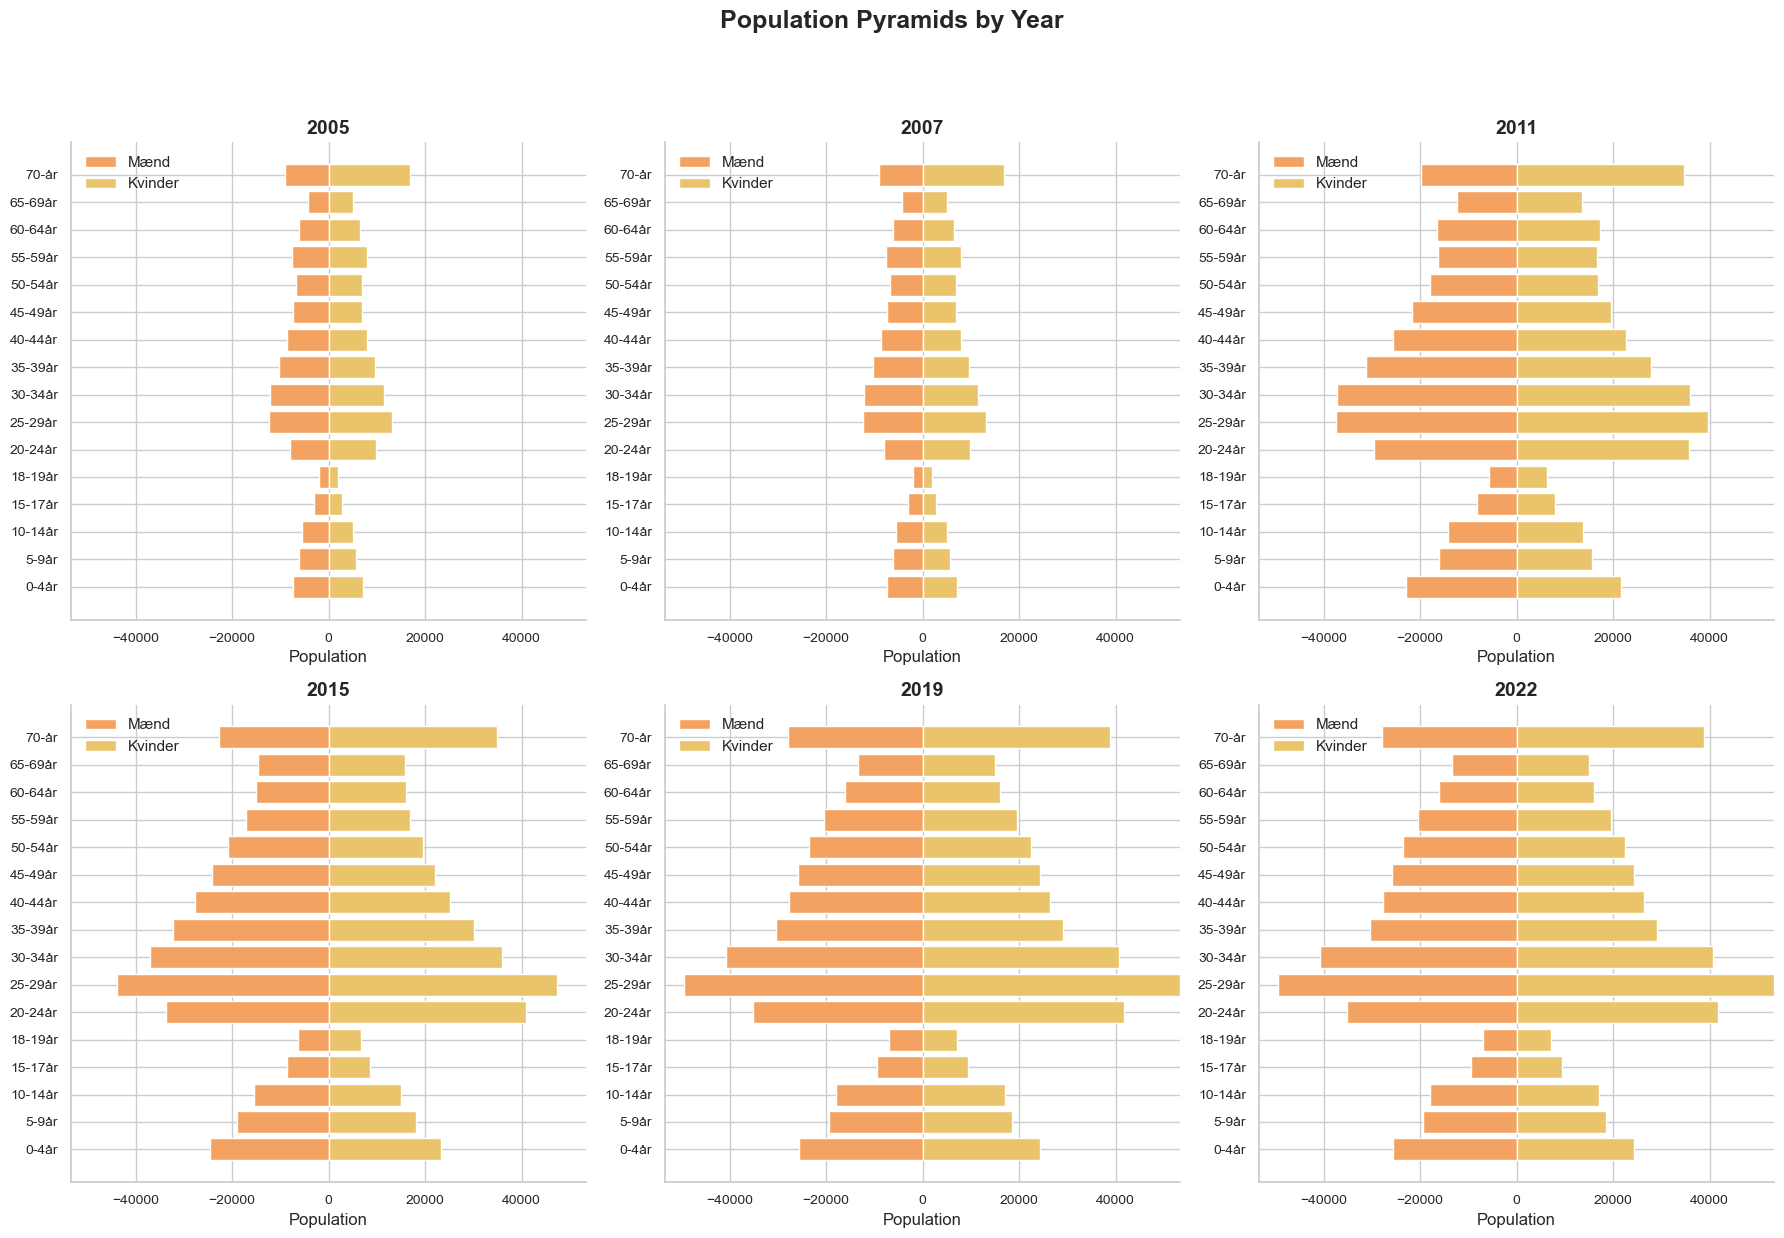

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Ensure Count is numeric
df_pop_demographics['Count'] = pd.to_numeric(df_pop_demographics['Count'], errors='coerce')

# Age order
age_order = [
    '0-4år', '5-9år', '10-14år', '15-17år', '18-19år', '20-24år',
    '25-29år', '30-34år', '35-39år', '40-44år', '45-49år',
    '50-54år', '55-59år', '60-64år', '65-69år', '70-år'
]

# Filter data
df = df_pop_demographics[
    df_pop_demographics['Gender'].isin(['Mænd', 'Kvinder']) &
    df_pop_demographics['Age'].isin(age_order)
]

# Color palette
color_m = '#F4A261'  # Warm orange
color_k = '#E9C46A'  # Soft yellow

# Setup subplots
years = sorted(df['Year'].unique())
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.flatten()

# 🔥 Step 1: Calculate global max population count for consistent x-axis
max_count = 0
for year in years[:6]:
    df_year = df[df['Year'] == year]
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    max_year = pop_by_age_gender.values.max()
    if max_year > max_count:
        max_count = max_year

# 🔁 Step 2: Plot each year's pyramid
for i, year in enumerate(years[:6]):
    ax = axs[i]
    df_year = df[df['Year'] == year]

    # Group data
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    pop_by_age_gender = pop_by_age_gender.loc[age_order]

    # Plot bars
    ax.barh(pop_by_age_gender.index, -pop_by_age_gender['Mænd'], color=color_m, label='Mænd')
    ax.barh(pop_by_age_gender.index, pop_by_age_gender['Kvinder'], color=color_k, label='Kvinder')

    # Title and labels
    ax.set_title(f"{year}", fontsize=14, weight='bold')
    ax.set_xlabel('Population')
    ax.set_xlim(-max_count, max_count)

    # Legend
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False)

    # Clean style
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Title and layout
plt.suptitle("Population Pyramids by Year", fontsize=18, weight='bold', y=1.03)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


## Get the housing size data

In [28]:
hoursing_size_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "boligstørrelse" in col
]

# Melt to long format
df_house_size = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=hoursing_size_columns,
    var_name='RawColumn',
    value_name='Count'
)

# Extract year, aggregate level, and size category
df_house_size[['Year', 'AggregateLevel', 'HourseSize']] = df_house_size['RawColumn'].str.extract(
    r'FV(\d{4})-Boligerogpersonerefterboligstørrelse_\d+\.(?:Antal)?(boliger|personer)_(.+)'
)

df_house_size['AggregateLevel'] = df_house_size['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns
df_house_size = df_house_size[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HourseSize', 'Count'
]]


In [29]:
df_house_size.head(3)

,Gruppe,KredsNr,Year,AggregateLevel,HourseSize,Count
0,101002,1,2015,Units,0-39m2,1884
1,101009,2,2015,Units,0-39m2,2509
2,101011,3,2015,Units,0-39m2,1305


## Get the housing type data

In [30]:
# Identify relevant boligtype columns
housing_type_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Boligtype" in col
]

# Melt the DataFrame
df_housing_type = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=housing_type_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract: year, aggregate level (boliger/personer), housing type
df_housing_type[['Year', 'AggregateLevel', 'HousingType']] = df_housing_type['RawColumn'].str.extract(
    r'FV(\d{4})-Boligtype_Antal_(boliger|personer)_\d+\.(.+)'
)

df_housing_type['AggregateLevel'] = df_housing_type['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns if you want
df_housing_type = df_housing_type[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HousingType', 'Count'
]]


In [31]:
df_housing_type.head(3)

,Gruppe,KredsNr,Year,AggregateLevel,HousingType,Count
0,101002,1,2015,Units,Stuehuseogparcelhuse,263
1,101009,2,2015,Units,Stuehuseogparcelhuse,2489
2,101011,3,2015,Units,Stuehuseogparcelhuse,163


## Get Ownership data

In [32]:
# Identify relevant boligtype columns
ownership_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Ejerforhold" in col
]

# Melt the DataFrame
df_ownership_type = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=ownership_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract: year, aggregate level (boliger/personer), housing type
df_ownership_type[['Year', 'AggregateLevel', 'OwnershipType']] = df_ownership_type['RawColumn'].str.extract(
    r'FV(\d{4})-Ejerforhold_Antal_(boliger|personer)_\d+\.(.+)'
)

df_ownership_type['AggregateLevel'] = df_ownership_type['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns if you want
df_ownership_type = df_ownership_type[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'OwnershipType', 'Count'
]]


In [33]:
df_ownership_type.head(3)

,Gruppe,KredsNr,Year,AggregateLevel,OwnershipType,Count
0,101002,1,2015,Units,Ejerbolig,6238
1,101009,2,2015,Units,Ejerbolig,6891
2,101011,3,2015,Units,Ejerbolig,4840


## Get Income data

In [34]:
# Step 1: Filter relevant income columns
income_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Husstandsindkomsterfordeltpåafstemningsområder" in col
]

# Step 2: Melt
df_income = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=income_cols,
    var_name='RawColumn',
    value_name='Value'
)

# Step 3: Extract Year + IncomeMetric
df_income[['Year', 'IncomeMetric']] = df_income['RawColumn'].str.extract(
    r'FV(\d{4})-Husstandsindkomsterfordeltpåafstemningsområder_(.+)'
)

# Step 4: Clean up
df_income = df_income.drop(columns='RawColumn')
df_income = df_income[[
    'Gruppe', 'KredsNr', 'Year', 'IncomeMetric', 'Value'
]]


In [35]:
df_income.head(3)

,Gruppe,KredsNr,Year,IncomeMetric,Value
0,101002,1,2015,100.000-149.999kr,1717
1,101009,2,2015,100.000-149.999kr,1600
2,101011,3,2015,100.000-149.999kr,1074


## Get Education data

In [36]:
educ_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Højstfuldførteerhvervsuddannelseogaldersgrupper" in col
]

# Melt the DataFrame
df_pop_educ = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=educ_columns,
    var_name='RawColumn',
    value_name='Count'
)

# Extract the fields using regex
# Pattern: FV<year>-Højstfuldførteer..._<Age>_<EducationLevel>
df_pop_educ[['Year', 'Age', 'EducationLevel']] = df_pop_educ['RawColumn'].str.extract(
    r'FV(\d{4})-Højstfuldførteerhvervsuddannelseogaldersgrupper_(\d{1,3}-?\d*år)(?:_(?:\d+\.)?(.+))?$'
)

# Remove 'år' from age
df_pop_educ['Age'] = df_pop_educ['Age'].str.replace('år', '', regex=False)

# Reorder and clean
df_pop_educ = df_pop_educ.drop(columns=['RawColumn'])
df_pop_educ = df_pop_educ[['Gruppe', 'KredsNr', 'Year', 'Age', 'EducationLevel', 'Count']]

# hvordan skal vi håndtere de manglende værdier i 'EducationLevel'?
# df_pop_educ['EducationLevel'] = df_pop_educ['EducationLevel'].fillna('Uoplyst')
# så skal vi summe count for Uoplyst og nan 

In [37]:
df_pop_educ.head(3)

,Gruppe,KredsNr,Year,Age,EducationLevel,Count
0,101002,1,2015,18-19,Grundskole,854
1,101009,2,2015,18-19,Grundskole,763
2,101011,3,2015,18-19,Grundskole,635


## Get Socio Economic data

In [38]:
# Select relevant columns for socio-economic status and industries
socioeconomic_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder" in col
]

# Melt to long format
df_socio = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=socioeconomic_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract Year, Employment Group, and Industry
df_socio[['Year', 'EmploymentGroup', 'Industry']] = df_socio['RawColumn'].str.extract(
    r'FV(\d{4})-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_\d+\.(.+?)_(.+)'
)

# Clean up columns
df_socio = df_socio.drop(columns=['RawColumn'])
df_socio = df_socio[['Gruppe', 'KredsNr', 'Year', 'EmploymentGroup', 'Industry', 'Count']]


In [39]:
df_socio.head(3)

,Gruppe,KredsNr,Year,EmploymentGroup,Industry,Count
0,101002,1,2015,Selvstændigogmedhj.,Byggeoganlæg,135
1,101009,2,2015,Selvstændigogmedhj.,Byggeoganlæg,107
2,101011,3,2015,Selvstændigogmedhj.,Byggeoganlæg,77


## Get support data

In [40]:
support_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Personerefterforsørgelsestype" in col
]

# Melt the DataFrame
df_support = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=support_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract Year and SupportType
df_support[['Year', 'SupportType']] = df_support['RawColumn'].str.extract(
    r'FV(\d{4})-Personerefterforsørgelsestype_\d+\.(.+)'
)

# Clean up
df_support = df_support.drop(columns='RawColumn')
df_support = df_support[['Gruppe', 'KredsNr', 'Year', 'SupportType', 'Count']]


In [41]:
df_support.head(3)

,Gruppe,KredsNr,Year,SupportType,Count
0,101002,1,2015,Arbejdsløshedsdagpenge,4618
1,101009,2,2015,Arbejdsløshedsdagpenge,4029
2,101011,3,2015,Arbejdsløshedsdagpenge,2966


## Get origin data

In [42]:
# Filter relevant columns
origin_cols = [
    col for col in df_population_cph.columns
    if "Indvandrereogefterkommerefordeltefteroprindelsesland" in col
]

# Melt to long format
df_origin_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=origin_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract year, gender, age, origin
df_origin_long[['Year', 'GenderAge', 'Origin']] = df_origin_long['RawColumn'].str.extract(
    r'FV(\d{4})-Indvandrereogefterkommerefordeltefteroprindelsesland_(\D+\d+-?\d*år)_(?:\d+\.)?(.+)$'
)

# Split gender and age
df_origin_long[['Gender', 'Age']] = df_origin_long['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Clean up
df_origin_long = df_origin_long.drop(columns=['RawColumn', 'GenderAge'])
df_origin_long['Age'] = df_origin_long['Age'].str.replace('år', '', regex=False)


In [43]:
df_origin_long.head(3)

,Gruppe,KredsNr,Count,Year,Origin,Gender,Age
0,101002,1,20,2015,Nordiskelande,Kvinder,0-4
1,101009,2,36,2015,Nordiskelande,Kvinder,0-4
2,101011,3,22,2015,Nordiskelande,Kvinder,0-4
